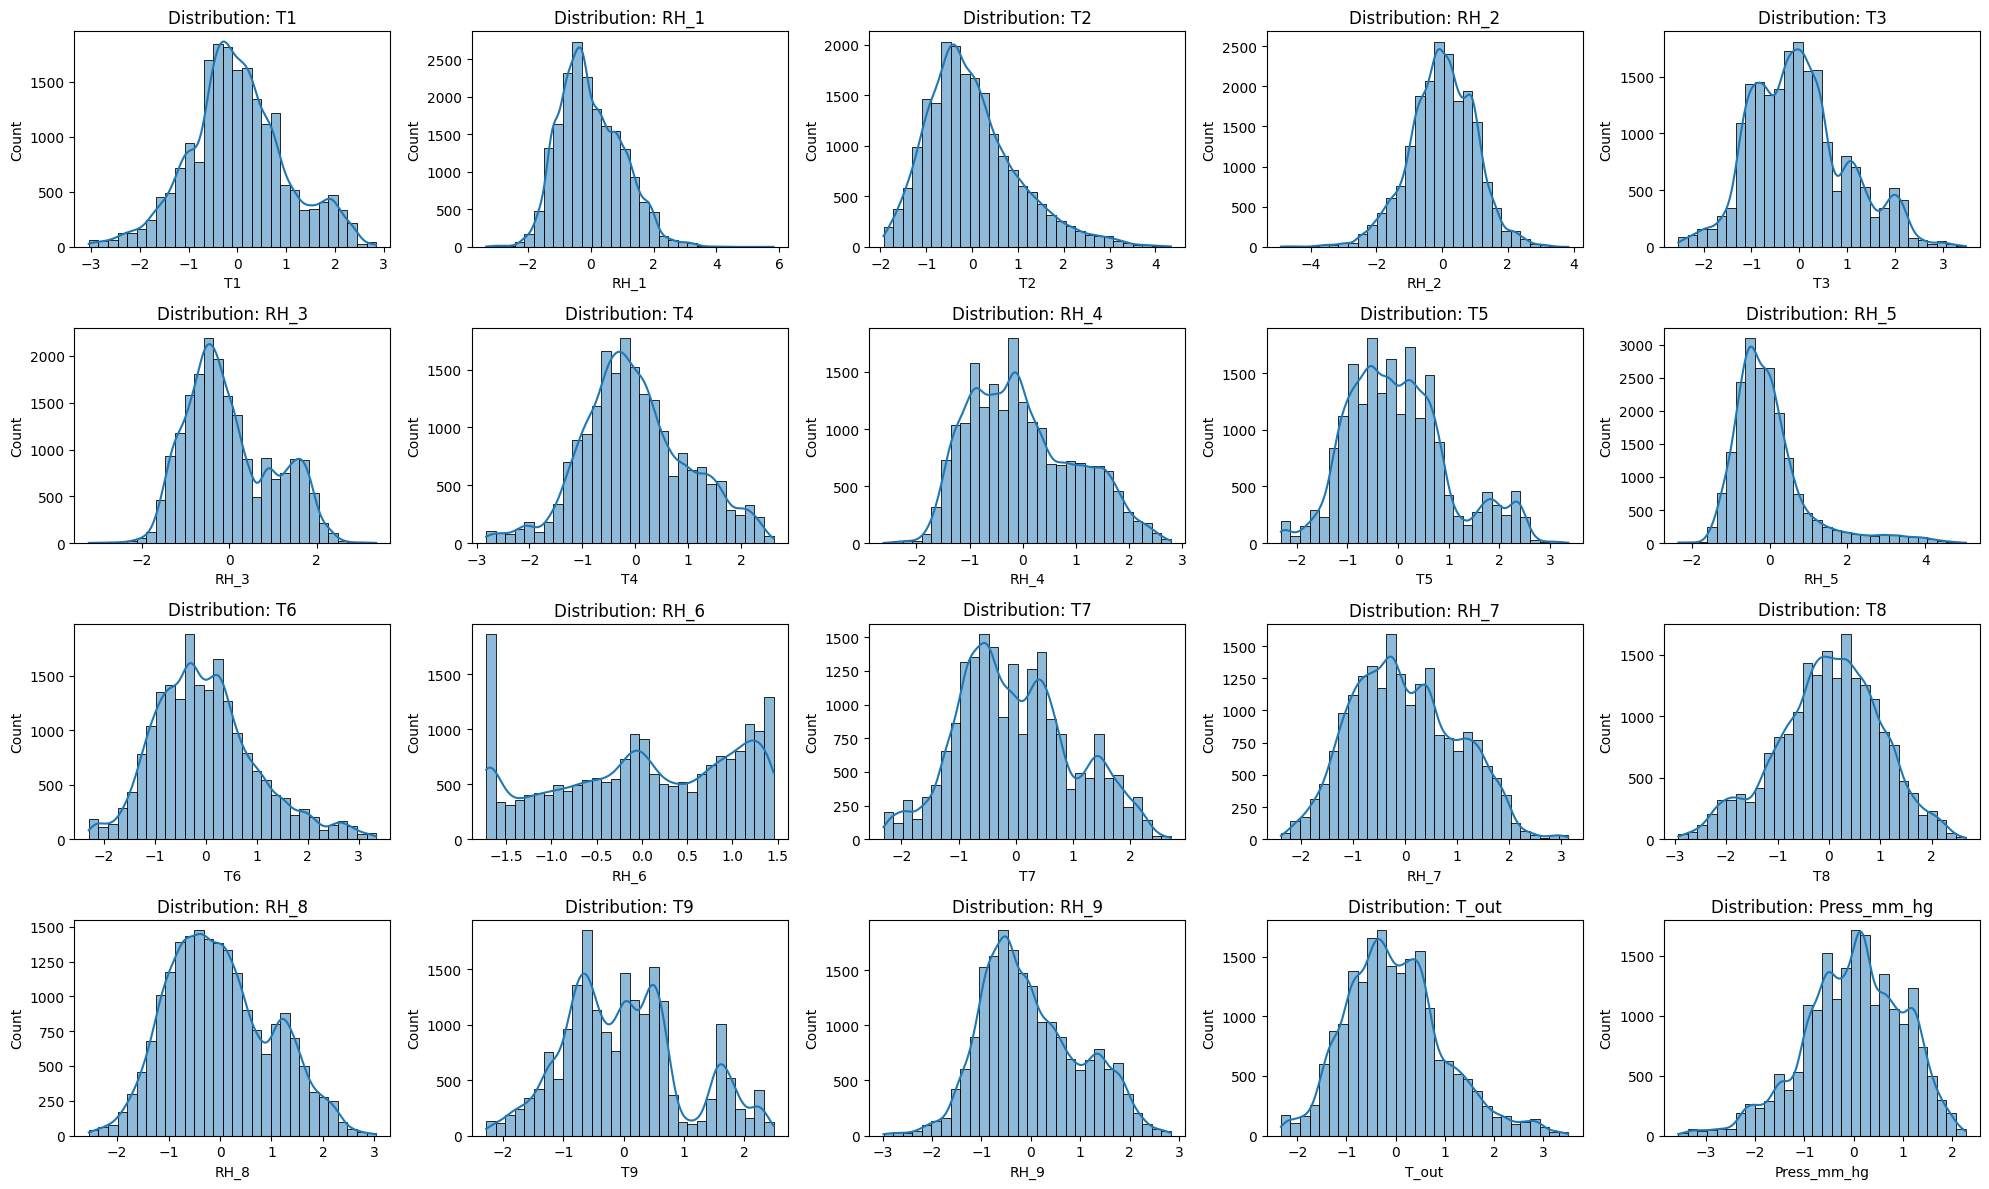

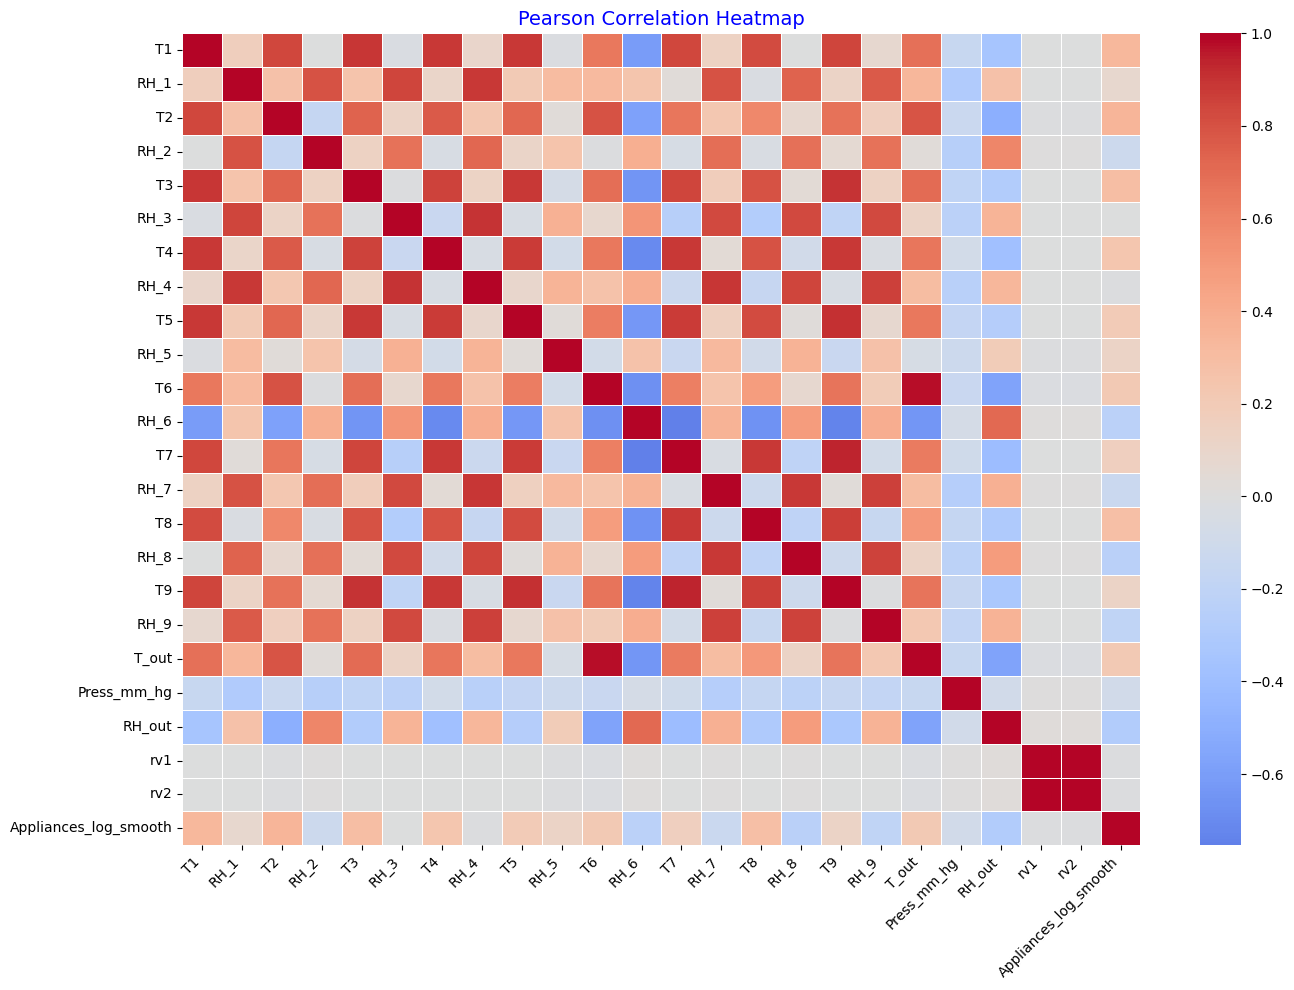

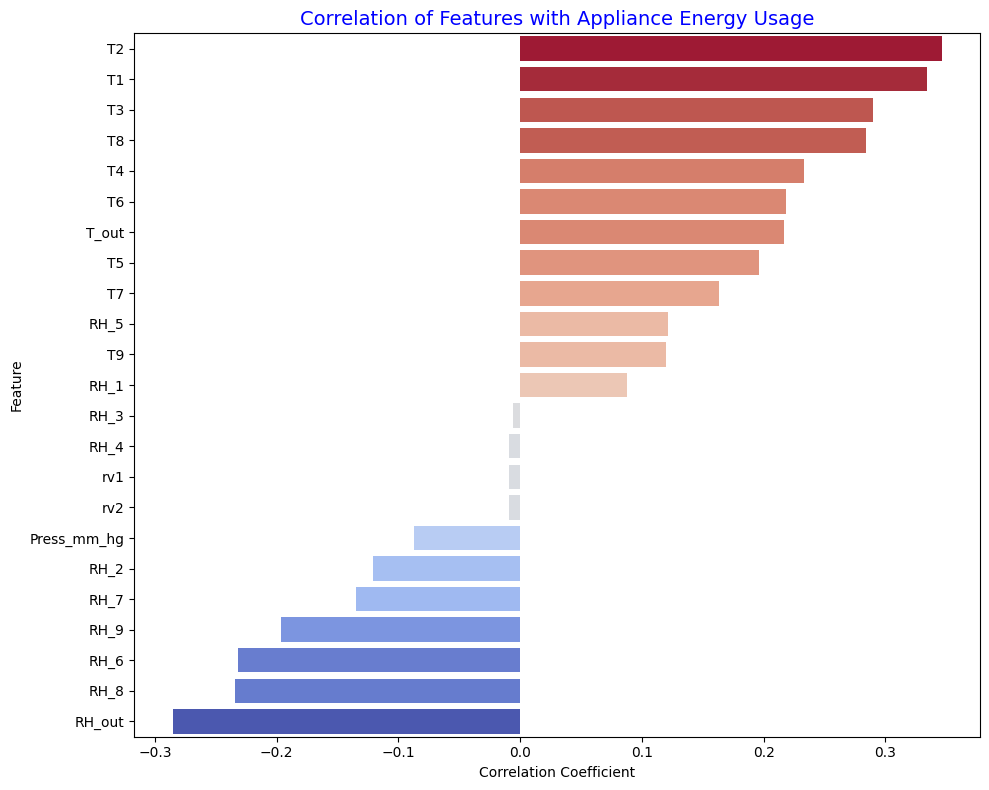

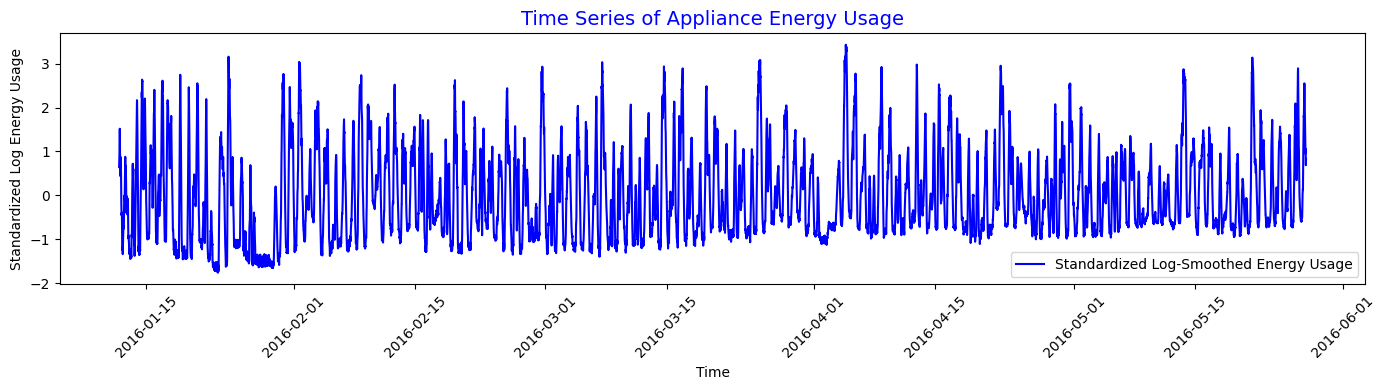

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------- Load and Preprocess the Original Dataset--------------------
df = pd.read_csv("/Users/zhongyucheng/Desktop/Spring2025/ACMS60890/final_project/ACMS60890_SP25_final_project/codes/EDA/energydata_complete.csv")
df['date'] = pd.to_datetime(df['date'])

# Drop unused or weakly correlated columns
unused = ['Windspeed', 'Visibility', 'Tdewpoint', 'lights']
df = df.drop(columns=unused)

# Log-transform the target
df['Appliances_log'] = np.log1p(df['Appliances'])

# Apply 24-sample moving average
df['Appliances_log_smooth'] = df['Appliances_log'].rolling(window=24).mean()

# Drop rows with NaNs from smoothing
df = df.dropna(subset=['Appliances_log_smooth']).reset_index(drop=True)

# Standardize input features
features = [col for col in df.columns if col not in ['date', 'Appliances', 'Appliances_log', 'Appliances_log_smooth']]
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(df[features]), columns=features)

# Standardize target
scaler_y = StandardScaler()
y_scaled = pd.Series(scaler_y.fit_transform(df[['Appliances_log_smooth']]).flatten(), name='Appliances_log_smooth')

# Combine with date for final dataset
data_processed = pd.concat([df[['date']], X_scaled, y_scaled], axis=1)

# -------------------- Distribution of Variables Plot --------------------
plt.figure(figsize=(20, 12))
for i, col in enumerate(features[:20]): 
    plt.subplot(4, 5, i+1)
    sns.histplot(data_processed[col], kde=True, bins=30)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.savefig("new_figures/distribution_of_variables.pdf", bbox_inches='tight')
plt.show()

# -------------------- Correlation Heatmap --------------------
plt.figure(figsize=(14, 10))
corr_matrix = data_processed.drop(columns='date').corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Pearson Correlation Heatmap', fontsize=14, color='blue')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("new_figures/correlation heatmap.pdf", bbox_inches='tight')
plt.show()

# -------------------- Feature-Target Correlation --------------------
target_corr = corr_matrix['Appliances_log_smooth'].drop('Appliances_log_smooth').sort_values(ascending=False)
norm = mcolors.TwoSlopeNorm(vmin=target_corr.min(), vcenter=0, vmax=target_corr.max())
colors = cm.coolwarm(norm(target_corr.values))
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
plt.title('Correlation of Features with Appliance Energy Usage', fontsize=14, color='blue')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("new_figures/feature-target correlation plot.pdf", bbox_inches='tight')
plt.show()

# -------------------- Time Series Plot --------------------
plt.figure(figsize=(14, 4))
plt.plot(data_processed['date'], data_processed['Appliances_log_smooth'], label='Standardized Log-Smoothed Energy Usage', color='blue')
plt.title("Time Series of Appliance Energy Usage", fontsize=14, color='blue')
plt.xlabel("Time")
plt.ylabel("Standardized Log Energy Usage")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/ts plot.pdf", bbox_inches='tight')
plt.show()

# -------------------- Export Cleaned Dataset --------------------
data_processed.to_csv("energydata_cleaned.csv", index=False)